In [1]:
import os
from glob import glob
import threading

import numpy as np
import dask.dataframe as dd
from dask import delayed
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt
#import matplotlib.animation as anima

import crocosi.postp as pp
from crocosi.jet import set_relevant_time
import phdequinox.sim_drifter as sdr

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.7/site-packages/distributed/utils.py:133: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [ ]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
w = cluster.scale(28*2)

In [2]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
#client = Client(cluster) # with distributed cluster

In [3]:
client

Client Scheduler: tcp://127.0.0.1:43786 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 107.37 GB


In [4]:
#root_path = '/home/datawork-lops-osi/slgentil/croco/jetn/'
#root_path = '/home1/datawork/slgentil/'#jet_cfg1_wp75_4km_1500a2000j_floats_lev50
root_path = '/home/c11-data/Test_aponte/jetn/'
run = 'jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/'

In [5]:
dr = sdr.drifter_dataframe(root_path+run, tdir_max=1)

In [6]:
t0 = 1550
t1 = 1565
tmid = (t0+t1)/2
flt_id = 225

In [7]:
gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.CROCOrun(root_path+run, prefix='file_', open_nc=['surf'], 
                chunk_time={'his': 1, 'surf': 1}, grid_params=gparams)

ds = r['surf']#.assign_coords(time=ds.time_counter)

dxy = 4
dsi = ds.assign_coords(time=ds.time_counter).sel(time=slice(1500,1600)).isel(s_rho_slice0=0)
dsi = dsi.assign_coords(x_rho=dsi.x_rho*dxy,y_rho=dsi.y_rho*dxy,x_u=dsi.x_u*dxy,y_v=dsi.y_v*dxy)

In [8]:
flt1 = dr.df.groupby('id').get_group(flt_id).compute().sort_values('time').set_index('time')

In [9]:
Time = flt1.loc[t0:t1].index

In [10]:
dsg = (dsi.u.shift(time=1)+dsi.u)/2

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:44393 remote=tcp://127.0.0.1:43786>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:44394 remote=tcp://127.0.0.1:43786>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:44395 remote=tcp://127.0.0.1:43786>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:44396 remote=tcp://127.0.0.1:43786>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:44398 remote=tcp://127.0.0.1:43786>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:44399 remote=tcp://127.0.0.1:43786>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:44400 remote=tcp://127.0.0.1:43786>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:44401 remote=tcp://127.0.0.1:43786>
distribu

In [11]:
dst = dsg.sel(time=slice(t0-2/(12*24),t1))

In [12]:
ds_zoom = dst.sel(x_u = slice(flt1.x.loc[t0:t1].min()-40,flt1.x.loc[t0:t1].max()+40),
        y_rho = slice(flt1.y.loc[t0:t1].min()-40,flt1.y.loc[t0:t1].max()+40))

In [21]:
posmean = flt1[['xgrid','ygrid']].loc[t0:t1].mean()#[tmid] 
xmean,ymean = [posmean.xgrid,posmean.ygrid]
xlim = [flt1['xgrid'].loc[t0:t1].min()*4,flt1['xgrid'].loc[t0:t1].max()*4]
x0,y0 = [flt1['xgrid'].loc[t0],flt1['ygrid'].loc[t0]]

In [14]:
def distance(x,y,x0,y0):
    return np.sqrt((x-x0)**2+(y-y0)**2)

In [15]:
dsu = dst.sel(y_rho=ymean*4,x_u=xmean*4,method='nearest').compute()

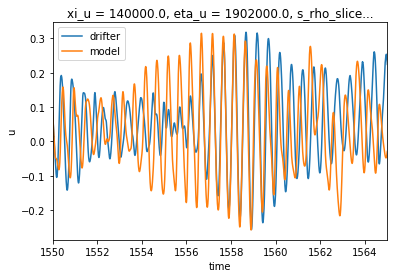

In [16]:
flt1.loc[t0:t1].u.plot(label='drifter')
dsu.plot(label='model')
plt.legend()

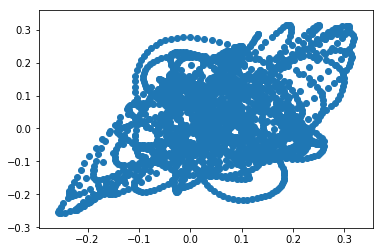

In [17]:
plt.scatter(flt1.loc[t0:t1].u,dsu)

(2161,)

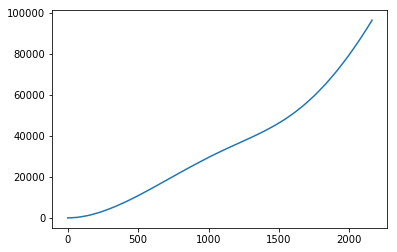

In [21]:
plt.plot(distance([x for x in flt1.xgrid.loc[t0:t1]*4],[y for y in flt1.ygrid.loc[t0:t1]*4],x0*4,y0*4).cumsum())
distance([x for x in flt1.xgrid.loc[t0:t1]*4],[y for y in flt1.ygrid.loc[t0:t1]*4],x0*4,y0*4).cumsum().shape

In [10]:
X,Y = [np.around(flt1.xgrid.loc[t0:t1]*4,decimals=0),flt1.ygrid.loc[t0:t1]*4]

In [27]:
dsu_time = dst.sel(time=tmid,method='nearest').compute()

In [26]:
dsu_space = dsu_time.sel(y_rho=flt1.loc[t0:t1].y.values,method='nearest').compute()

In [29]:
dsu_space = dus_space.sel(x_u=flt1.loc[t0:t1].x.values,method='nearest').compute()

In [32]:
DS=[]
for t in flt1.loc[t0:t1].index:
    DS.append(dsu_time.sel(y_rho=flt1.loc[t].y,x_u=flt1.loc[t].x,method='nearest').values)

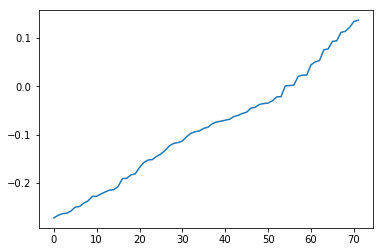

In [52]:
plt.plot(np.unique(DS))

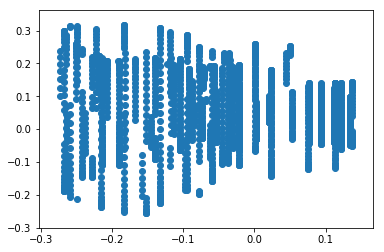

In [50]:
plt.scatter(DS,flt1.loc[t0:t1].u)

(Text(0.5,0,'$x_{\\rho}$'), Text(0,0.5,'$y_{\\rho}$'))

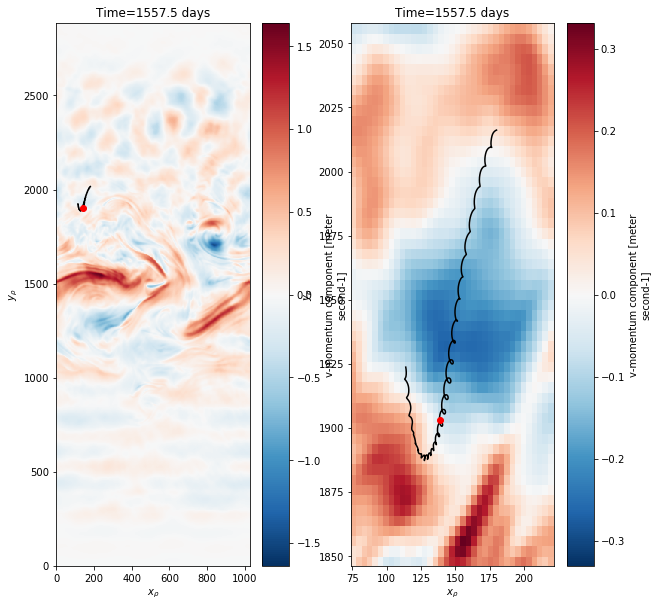

In [23]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2,1)
#Dsu.sel(x_u = slice(flt1.x.loc[t0:t1].min()-40,flt1.x.loc[t0:t1].max()+40),
#        y_rho = slice(flt1.y.loc[t0:t1].min()-40,flt1.y.loc[t0:t1].max()+40)).plot(ax=ax)
dsi.u.sel(time=tmid,method='nearest').plot(ax=ax)
ax.plot(flt1.x.loc[t0:t1],flt1.y.loc[t0:t1],c='k')
ax.plot(flt1.x.loc[tmid],flt1.y.loc[tmid],marker='o',c='r')
ax.set_aspect('equal');ax.set_title('Time=%s days'%tmid)
ax.set_xlabel(r'$x_{\rho}$'),ax.set_ylabel(r'$y_{\rho}$')
ax = fig.add_subplot(1,2,2)
dsi.u.sel(x_u = slice(flt1.x.loc[t0:t1].min()-40,flt1.x.loc[t0:t1].max()+40),
        y_rho = slice(flt1.y.loc[t0:t1].min()-40,flt1.y.loc[t0:t1].max()+40)).sel(time=tmid,method='nearest').plot(ax=ax)
ax.plot(flt1.x.loc[t0:t1],flt1.y.loc[t0:t1],c='k')
ax.plot(flt1.x.loc[tmid],flt1.y.loc[tmid],marker='o',c='r')
ax.set_title('Time=%s days'%tmid)
ax.set_xlabel(r'$x_{\rho}$'),ax.set_ylabel(r'$y_{\rho}$')

Text(0.5,0.98,'Time=1557.5 days')

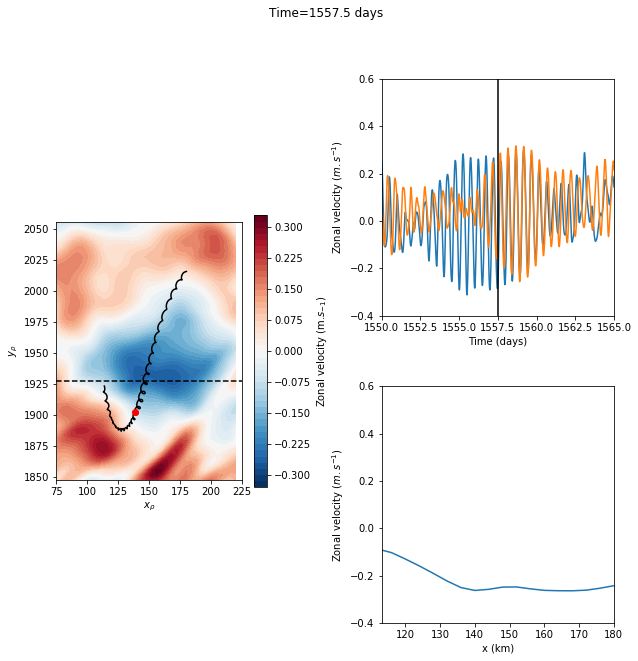

In [22]:
fig = plt.figure(figsize=(10,10))
grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)
ax = plt.subplot(grid[:,0])
cs = ds_zoom.sel(time=tmid,method='nearest').plot.contourf(ax=ax,add_colorbar=False,levels=50)
plt.colorbar(cs,shrink=0.5,label=r'Zonal velocity (m.$s_{-1}$)')
#ax.plot(flt1.x.loc[t0:t1],flt1.y.loc[t0:t1],c='k',title=None)
flt1.loc[t0:t1].plot(x='x',y='y',ax=ax,kind='line',c='k',xlim=(75,225),title=None,legend=None)
ax.plot(flt1.x.loc[tmid],flt1.y.loc[tmid],marker='o',c='r')
ax.axhline(y=ymean*4,c='k',linestyle='--')
ax.set_aspect('equal')
ax.set_title('')
ax.set_xlabel(r'$x_{\rho}$'),ax.set_ylabel(r'$y_{\rho}$')
#ax.set_aspect('equal')
ax = plt.subplot(grid[0,1])
dst.sel(x_u=xmean*4,y_rho=ymean*4,method='nearest').plot(ax=ax,xlim=(t0,t1),ylim=(-0.4,0.6))
flt1[['u']].plot(ax=ax,xlim=(t0,t1),ylim=(-0.4,0.6),title=None,legend=None)
ax.axvline(x=tmid,c='k')
ax.set_xlabel('Time (days)');ax.set_ylabel('Zonal velocity ($m.s^{-1})$')
ax.set_title('')
ax = plt.subplot(grid[1,1])
dst.sel(time = tmid,y_rho=ymean*4,method='nearest').plot(ax=ax,xlim=xlim,ylim=(-0.4,0.6))
ax.set_xlabel('x (km)');ax.set_ylabel('Zonal velocity ($m.s^{-1})$')
ax.set_title('')
fig.suptitle('Time=%s days'%tmid)

In [152]:
print('Time %s'%np.around(1550.00069,decimals=1))

Time 1550.0


In [53]:
def genfig(t,figsize,figdir, overwrite=True,offline=True):
    figname = figdir+'flt225_t%s' %(np.around(t, decimals=1))+'.png'
    if not os.path.isfile(figname) or overwrite:
        MPL_LOCK = threading.Lock()
        with MPL_LOCK:
            plt.switch_backend('agg')    
            fig = plt.figure(figsize=figsize)
            grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.3)
            ax = plt.subplot(grid[:,0])
            cs = ds_zoom.sel(time=t,method='nearest').plot.contourf(ax=ax,vmax = 0.6,vmin = -0.6,cmap = 'RdBu_r',add_colorbar=False,levels=50)
            plt.colorbar(cs,shrink=0.5,label=r'Zonal velocity (m.$s_{-1}$)')
            #ax.plot(flt1.x.loc[t0:t1],flt1.y.loc[t0:t1],c='k',title=None)
            flt1.loc[t0:t1].plot(x='x',y='y',ax=ax,kind='line',c='k',xlim=(75,225),title=None,legend=None)
            ax.plot(flt1.x.loc[t],flt1.y.loc[t],marker='o',c='r')
            ax.plot(xmean*4,ymean*4,c='b',marker='d')
            ax.axhline(y=ymean*4,c='k',linestyle='--')
            ax.set_aspect('equal')
            ax.set_title('')
            ax.set_xlabel(r'$x_{\rho}$'),ax.set_ylabel(r'$y_{\rho}$')
            ax = plt.subplot(grid[0,1])
            dst.sel(x_u=xmean*4,y_rho=ymean*4,method='nearest').plot(ax=ax,xlim=(t0,t1),ylim=(-0.4,0.6))
            flt1[['u']].plot(ax=ax,xlim=(t0,t1),ylim=(-0.4,0.6),title=None,legend=None)
            ax.axvline(x=t,c='k')
            ax.set_xlabel('Time (days)');ax.set_ylabel('Zonal velocity ($m.s^{-1})$')
            ax.set_title('')
            ax = plt.subplot(grid[1,1])
            dst.sel(time = t,y_rho=ymean*4,method='nearest').plot(ax=ax,xlim=xlim,ylim=(-0.4,0.6))
            ax.set_xlabel('x (km)');ax.set_ylabel('Zonal velocity ($m.s^{-1})$')
            ax.set_title('')
            fig.suptitle('Time=%s days'%t)
            if offline:
                fig.savefig(figname)
                plt.close()
            m = 1.
    else:
        m = -1.
    return m

In [54]:
Time[::6*6]

Float64Index([ 1550.0, 1550.25,  1550.5, 1550.75,  1551.0, 1551.25,  1551.5,
              1551.75,  1552.0, 1552.25,  1552.5, 1552.75,  1553.0, 1553.25,
               1553.5, 1553.75,  1554.0, 1554.25,  1554.5, 1554.75,  1555.0,
              1555.25,  1555.5, 1555.75,  1556.0, 1556.25,  1556.5, 1556.75,
               1557.0, 1557.25,  1557.5, 1557.75,  1558.0, 1558.25,  1558.5,
              1558.75,  1559.0, 1559.25,  1559.5, 1559.75,  1560.0, 1560.25,
               1560.5, 1560.75,  1561.0, 1561.25,  1561.5, 1561.75,  1562.0,
              1562.25,  1562.5, 1562.75,  1563.0, 1563.25,  1563.5, 1563.75,
               1564.0, 1564.25,  1564.5, 1564.75,  1565.0],
             dtype='float64', name='time')

In [ ]:
figdir = '/home1/datahome/zcaspar/figs/'
for t in Time[::6*6] : 
    print(t)
    genfig(t,(10,10),figdir,overwrite=True,offline=True)

1550.0
1550.25
1550.5
1550.75
1551.0
1551.25
1551.5
1551.75
1552.0
1552.25
1552.5
1552.75
1553.0
1553.25
1553.5
1553.75
1554.0
1554.25


In [ ]:
def genfig(i, ds, v, flt, n, size, overwrite=True, offline=True):
    
    figname = figdir+'float_%s_t%05d_%s' %(v, n, size)+'.png'
    
    if not os.path.isfile(figname) or overwrite:
        time = ds['time_instant'].values
        
        #
        MPL_LOCK = threading.Lock()
        with MPL_LOCK:
            plt.switch_backend('agg')    
            #
            flti = flt.loc[i]
            fig = plt.figure(figsize=(10,10))
            grid = plt.GridSpec(3, 1, wspace=0.4, hspace=0.3)
    
            ax = plt.subplot(grid[2, :])
    #off1 = .5
            ax.plot(flt.index,flt.u)
            ax.axvline(x=i, color='k', lw=1)
            ax.set_xlabel('Time (days)');ax.set_ylabel(r'Zonal velocity ($m.s^{-1}$)')
            ax = plt.subplot(grid[:2, :])    
            ax.plot(flt.x, flt.y)
   
            ax.plot(flti.x, flti.y, marker='d', ms=8, 
                    markeredgecolor='k')
            ds.plot.contourf(ax=ax, levels = np.linspace(-1,0,20), cmap='RdBu_r')
            ax.set_xlabel(r'$x_\rho$');ax.set_ylabel(r'$y_\rho$')
            ax.set_title(r'Time$\simeq$%sdays'%np.around(i,decimals=1))
            if offline:
                fig.savefig(figname)
                plt.close()
            #
            m = 1.
    else:
        m = -1.
    return m